In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import time
import copy
import sys
import torch.nn.init as init
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [3]:
runs_list = next(os.walk('../Data/Images'))[1]

In [4]:
path = "../Data/Labels.csv"
header = ['Run','AD']
Labelsdf = pd.read_csv(path, names=header, usecols=[1,2], skiprows=1, index_col=False)

In [5]:
labels_dict = dict(zip(Labelsdf.Run, Labelsdf.AD))

In [6]:
import re

# process then save the 3d image ndarray as binary
# Images of 96, 96, 48 from 256, 176, 256

# Crop in the x and y direction (get center/hippocampi area)
# [80:176, 40:136, ]

img_dir = "../Data/Images"
dest_dir = "../Data/Processed"

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    print("Created ouput directory: " + dest_dir)

    depth_scale = 2

    imgs, labels = [], []

    for run in runs_list:
        run_dir = os.path.join(img_dir, run)
        run_imgs = []
        for filename in os.listdir(run_dir):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            # if image is square? IF DO THIS, NEED TO ACCOUNT FOR CENTER OFF SET (176 X 240)
            if  img_slice is None or img_slice.shape[0] == img_slice.shape[1]:
                print(run)
                print('1')
                break
            img_num = int(filename[-7:-4])
            if (100 <= img_num < 196):
                img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
                #img_slice = cv2.resize(img_slice, (0,0), fx=1/img_scale, fy=1/img_scale, interpolation=cv2.INTER_AREA)
                img_slice = img_slice[80:176,40:136]
                # normalize pixel intensity to range of 0 and 1
                img_slice = img_slice/256
                run_imgs.append(img_slice)

        if len(run_imgs) == 0 or len(run_imgs) != 96:
            print(run)
            print('2')
            continue

        temp_arr = np.array(run_imgs)

        final_slices = []

        for y in range(temp_arr.shape[2]):
            xz_pane = temp_arr[:, :, y]
            scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
            final_slices.append(scaled_xz)

        if not len(final_slices[0]) == 48:
            print(run)
            print('3')
            continue

        final_slices = np.dstack(final_slices)
        final_slices = np.expand_dims(final_slices, axis=0)
        if run in labels_dict:
            # save as binary
            np.save(os.path.join(dest_dir, run), final_slices)
            imgs.append(run)
            labels.append(labels_dict[run])
        else:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    np.save(os.path.join(dest_dir, 'imgs'), imgs)
    np.save(os.path.join(dest_dir, 'labels'), labels)

            
else:
    imgs = np.load(os.path.join(dest_dir, 'imgs.npy'))
    labels = np.load(os.path.join(dest_dir, 'labels.npy'))

In [7]:
# Models to choose from
model_name = "resnet152"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 40

In [8]:
# train_imgs, train_labels = [], []
# val_imgs, val_labels = [], []
# test_imgs, test_labels = [], []

# for idx, ad in np.ndenumerate(labels):
#     if (idx[0] % 10) < 6:
#         train_imgs.append(imgs[idx[0]])
#         train_labels.append(ad)
#     if ((idx[0] % 10) >= 6) and ((idx[0] % 10) < 8):
#         val_imgs.append(imgs[idx[0]])
#         val_labels.append(ad)
#     if ((idx[0] % 10) >= 8) and ((idx[0] % 10) <= 9):
#         test_imgs.append(imgs[idx[0]])
#         test_labels.append(ad)
        
# train_imgs = np.array(train_imgs)
# train_labels = np.array(train_labels)
# val_imgs = np.array(val_imgs)
# val_labels = np.array(val_labels)
# test_imgs = np.array(test_imgs)
# test_labels = np.array(test_labels)
        
# ad_imgs, ad_labels = [], []

# for idx, ad in np.ndenumerate(train_labels):
#     if ad:
#         ad_imgs.append(imgs[idx[0]])
#         ad_labels.append(ad)

# ad_imgs = np.array(ad_imgs)
# ad_labels = np.array(ad_labels)

# normal_ratio = train_imgs.shape[0] // ad_imgs.shape[0]
# print("Normal ratio: " + str(normal_ratio))

# train_imgs = np.concatenate((train_imgs, np.repeat(ad_imgs, normal_ratio - 1, axis=0)), axis=0)
# train_labels = np.concatenate((train_labels, np.repeat(ad_labels, normal_ratio -1, axis=0)), axis=0)

In [9]:
train_imgs, train_labels = [], []
val_imgs, val_labels = [], []
test_imgs, test_labels = [], []

for idx, ad in np.ndenumerate(labels):
    if (idx[0] % 10) < 6:
        train_imgs.append(imgs[idx[0]])
        train_labels.append(ad)
    if ((idx[0] % 10) >= 6) and ((idx[0] % 10) < 8):
        val_imgs.append(imgs[idx[0]])
        val_labels.append(ad)
    if ((idx[0] % 10) >= 8) and ((idx[0] % 10) <= 9):
        test_imgs.append(imgs[idx[0]])
        test_labels.append(ad)
        
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)
val_imgs = np.array(val_imgs)
val_labels = np.array(val_labels)
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)
        
ad_imgs, ad_labels = [], []

import random

for idx, ad in np.ndenumerate(train_labels):
    if ad:
        ad_imgs.append(imgs[idx[0]])
        ad_labels.append(ad)

ad_imgs = np.array(ad_imgs)
ad_labels = np.array(ad_labels)

normal_ratio = train_imgs.shape[0] // ad_imgs.shape[0]
print("Normal ratio: " + str(normal_ratio))

print(train_imgs.shape)

idx_list = []
for idx, ad in np.ndenumerate(train_labels):
    if (not ad) and (random.random() > (1.0 / (normal_ratio))):
        idx_list.append(idx)

train_imgs = np.delete(train_imgs, idx_list)
train_labels = np.delete(train_labels, idx_list)
        
print(train_imgs.shape)
print(ad_imgs.shape)
        
# train_imgs = np.concatenate((train_imgs, np.repeat(ad_imgs, normal_ratio - 1, axis=0)), axis=0)
# train_labels = np.concatenate((train_labels, np.repeat(ad_labels, normal_ratio -1, axis=0)), axis=0)

Normal ratio: 7
(1664,)
(428,)
(224,)


In [10]:
class T1Dataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = np.load(os.path.join(dest_dir, self.data[index]) + ".npy")
        x = torch.from_numpy(x).float()
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [11]:
train_dataset = T1Dataset(train_imgs, train_labels)
val_dataset = T1Dataset(val_imgs, val_labels)
test_dataset = T1Dataset(test_imgs, test_labels)

image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size,
                                                   pin_memory=True,
                                                   shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}

In [12]:
class VGG3D(nn.Module):

    def __init__(self):
        super(VGG3D, self).__init__()
        
        self.features3d = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2)), #256
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2)), #128
            
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2)), #64
            
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2)), #32
            
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2)), #16
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 3, 3))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 3 * 3, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features3d(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 num_classes=400):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=2)
        last_duration = int(math.ceil(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.avgpool = nn.AvgPool3d(
            (last_duration, last_size, last_size), stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters


def resnet10(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            normal_corrects, ad_corrects = 0, 0
            normal_count, ad_count = 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                correctness = preds == labels.data
                running_corrects += torch.sum(correctness)

                index = 0
                for condition in labels.data:
                    
                    if condition == 0:
                        if correctness[index] == 1:
                            normal_corrects += 1
                        normal_count += 1
                    if condition == 1:
                        if correctness[index] == 1:
                            ad_corrects += 1
                        ad_count += 1
                    index += 1
    
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_normal_acc = normal_corrects / normal_count
            epoch_ad_acc = ad_corrects / ad_count

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('Normal Acc: {:.4f} AD Acc: {:.4f}'.format(epoch_normal_acc, epoch_ad_acc))
            print('Normal count: {} AD count: {}'.format(normal_count, ad_count))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc and abs(epoch_normal_acc - epoch_ad_acc) < 0.1:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
                print('New best_acc: {:.4f}'.format(best_acc))
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc (with true/false acc diff less than 10%): {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [15]:
def initialize_model(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = []

    if model_name == "vgg3d":
        model_ft = VGG3D()
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = (48, 96, 96)
        
    elif model_name == "resnet101":
        model_ft = resnet101(
                num_classes=num_classes,
                sample_size=96,
                sample_duration=48)
        
    elif model_name == "resnet152":
        model_ft = resnet152(
                num_classes=num_classes,
                sample_size=96,
                sample_duration=48)
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [16]:
scratch_model,_ = initialize_model(model_name, num_classes)
print(scratch_model)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.01, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv3d(64, 256, ker

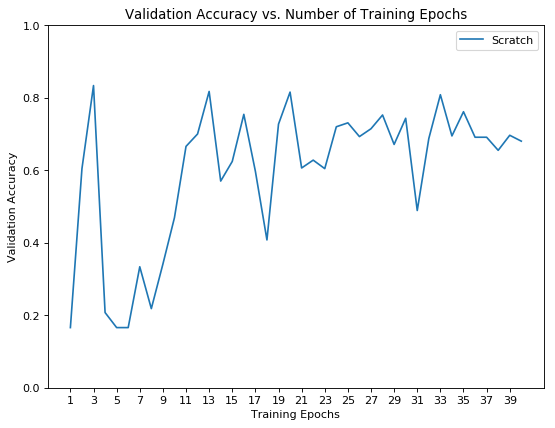

In [17]:
shist = []

from matplotlib.pyplot import figure
shist = [h.cpu().numpy() for h in scratch_hist]

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 2))
plt.legend()
plt.show()

In [18]:
print(os.getcwd())

torch.save(scratch_model.state_dict(), "./resnet152_run2.pth")

scratch_model = resnet152(
        num_classes=num_classes,
        sample_size=96,
        sample_duration=48)
scratch_model.load_state_dict(torch.load("./resnet152_run2.pth"))
scratch_model.eval()
scratch_model.to(device)

running_loss = 0.0
running_corrects = 0
normal_corrects, ad_corrects = 0, 0
normal_count, ad_count = 0, 0

for test_inputs, test_labels in test_dataset:
    test_inputs = test_inputs.unsqueeze(0)
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)
    
    with torch.no_grad():
        test_outputs = scratch_model(test_inputs)
#         test_loss = scratch_criterion(test_outputs, test_labels)
        _, test_preds = torch.max(test_outputs, 1)
        test_preds = test_preds.squeeze(0)
        print(test_outputs)
        print(test_preds)
        print(test_labels)
        print()
        
        # statistics
#     running_loss += test_loss.item() * test_inputs.size(0)
    correctness = test_preds == test_labels
    running_corrects += torch.sum(correctness)

    if test_labels == 0:
        if correctness == 1:
            normal_corrects += 1
        normal_count += 1
    if test_labels == 1:
        if correctness == 1:
            ad_corrects += 1
        ad_count += 1
    
#     epoch_loss = running_loss / len(test_dataset.dataset)
epoch_acc = running_corrects.double() / len(test_dataset)
epoch_normal_acc = normal_corrects / normal_count
epoch_ad_acc = ad_corrects / ad_count

print('{} Acc: {:.4f}'.format('test', epoch_acc))
print('Normal Acc: {:.4f} AD Acc: {:.4f}'.format(epoch_normal_acc, epoch_ad_acc))
print('Normal count: {} AD count: {}'.format(normal_count, ad_count))

/home/jupyter/aps360/notebook


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


tensor([[ 0.2084, -0.2669]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 0.6193, -0.6571]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 1.2882, -1.3195]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 2.3477, -2.3611]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 2.7548, -2.7698]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 2.8989, -2.9131]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 1.5179, -1.5396]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 1.8262, -1.8403]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[-4.2253,  5.0021]], device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')

tensor([[ 1.8757, -1.8889]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='